⬇Downloading johnsmith88/heart-disease-dataset...
Extracted files to './heart_data'
Dataset Sample:
   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   52    1   0       125   212    0        1      168      0      1.0      2   
1   53    1   0       140   203    1        0      155      1      3.1      0   
2   70    1   0       145   174    0        1      125      1      2.6      0   
3   61    1   0       148   203    0        1      161      0      0.0      2   
4   62    0   0       138   294    1        1      106      0      1.9      1   

   ca  thal  target  
0   2     3       0  
1   0     3       0  
2   0     3       0  
3   1     3       0  
4   3     2       0  

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1025 non-null   int64  
 1   sex       1025 non-null   int64  
 2 

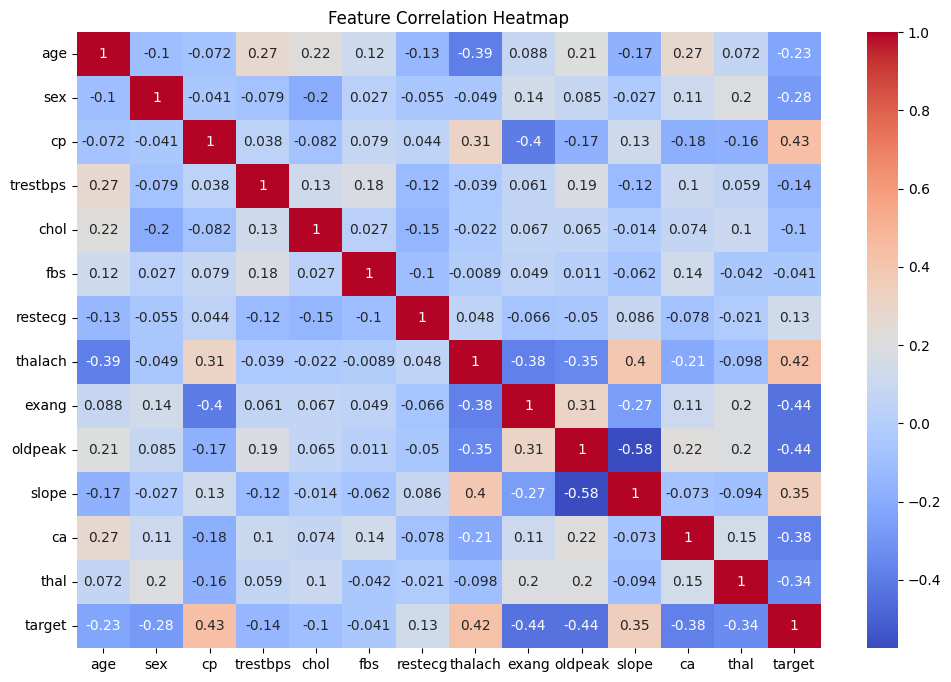

After SMOTE - Class Distribution: [421 421]

Training LogisticRegression...
Best Params for LogisticRegression: {'C': 10, 'penalty': 'l2'}
Cross-validated Accuracy: 85.39%

Training RandomForest...
Best Params for RandomForest: {'max_depth': None, 'n_estimators': 200}
Cross-validated Accuracy: 98.34%

Training XGBoost...
Best Params for XGBoost: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200}
Cross-validated Accuracy: 98.46%

Test Accuracy: 100.0 %

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       100
           1       1.00      1.00      1.00       105

    accuracy                           1.00       205
   macro avg       1.00      1.00      1.00       205
weighted avg       1.00      1.00      1.00       205



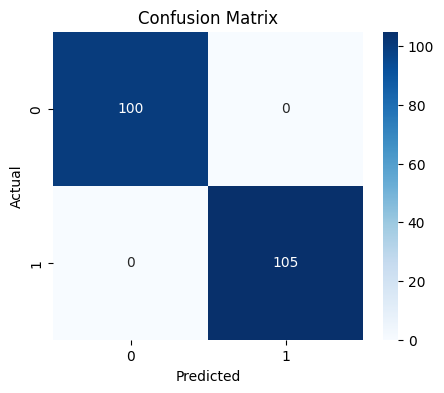

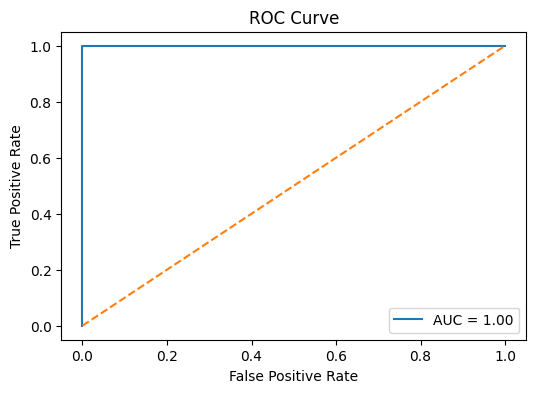

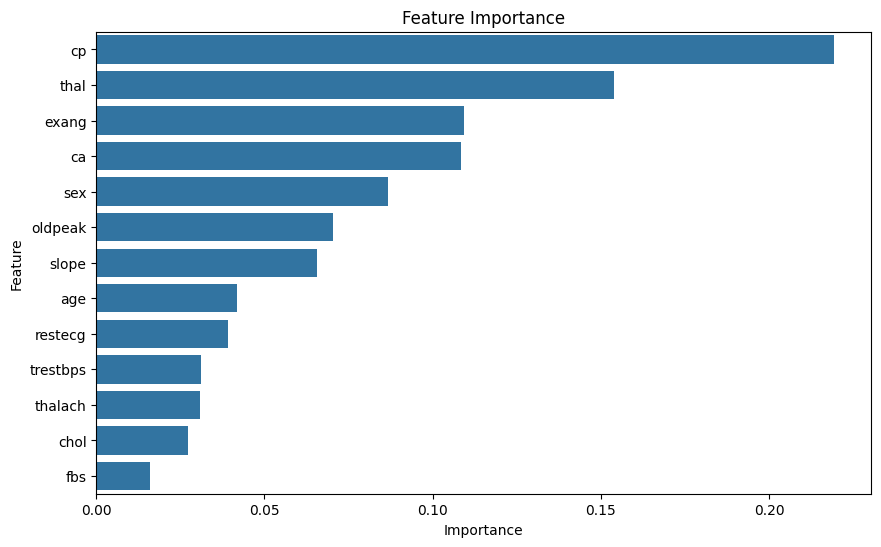


Full Pipeline saved as ./heart_disease_pipeline.pkl

Prediction for custom patient: Positive for Heart Disease
Probability of positive diagnosis: 98.00%

Enhanced Pipeline Complete!


In [ ]:
import os
import pandas as pd
import numpy as np
import urllib.request
from zipfile import ZipFile
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
import joblib
import warnings
warnings.filterwarnings('ignore')


dataset_name = 'johnsmith88/heart-disease-dataset'
download_path = './heart_data'

os.environ['KAGGLE_CONFIG_DIR'] = './'

if not os.path.exists(download_path):
    os.makedirs(download_path)

print(f"⬇Downloading {dataset_name}...")
os.system(f'kaggle datasets download -d {dataset_name} -p {download_path} --unzip')
print(f"Extracted files to '{download_path}'")

csv_file = f'{download_path}/heart.csv'
df = pd.read_csv(csv_file)

print("Dataset Sample:")
print(df.head())

print("\nDataset Info:")
print(df.info())

print("\nMissing Values:")
print(df.isnull().sum())

# Correlation Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

X = df.drop('target', axis=1)
y = df['target']

# Train-Test Split before SMOTE
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Handling Imbalance
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

print(f"After SMOTE - Class Distribution: {np.bincount(y_train_balanced)}")


# Logistic Regression
log_reg = LogisticRegression(solver='liblinear', random_state=42)
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2']
}

# Random Forest
rf = RandomForestClassifier(random_state=42)
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10]
}

# XGBoost
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

models = {
    'LogisticRegression': (log_reg, param_grid_lr),
    'RandomForest': (rf, param_grid_rf),
    'XGBoost': (xgb, param_grid_xgb)
}

best_models = {}

for name, (model, params) in models.items():
    print(f"\nTraining {name}...")
    grid = GridSearchCV(model, params, cv=StratifiedKFold(5), scoring='accuracy')
    grid.fit(X_train_balanced, y_train_balanced)
    best_models[name] = grid.best_estimator_
    print(f"Best Params for {name}: {grid.best_params_}")
    print(f"Cross-validated Accuracy: {grid.best_score_ * 100:.2f}%")

final_model = best_models['XGBoost']

y_pred = final_model.predict(X_test_scaled)
y_prob = final_model.predict_proba(X_test_scaled)[:, 1]

print("\nTest Accuracy:", accuracy_score(y_test, y_pred) * 100, "%")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='Blues', fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, y_prob):.2f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

if hasattr(final_model, 'feature_importances_'):
    importances = final_model.feature_importances_
    feature_names = X.columns
    feat_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    feat_imp_df.sort_values(by='Importance', ascending=False, inplace=True)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feat_imp_df)
    plt.title('Feature Importance')
    plt.show()

pipeline = Pipeline([
    ('scaler', scaler),
    ('classifier', final_model)
])

model_file = './heart_disease_pipeline.pkl'
joblib.dump(pipeline, model_file)

print(f"\nFull Pipeline saved as {model_file}")

new_patient = np.array([[63, 1, 3, 145, 233, 1, 0, 150, 0, 2.3, 0, 0, 1]])
prediction = pipeline.predict(new_patient)
probability = pipeline.predict_proba(new_patient)

result = "Positive for Heart Disease" if prediction[0] == 1 else "Negative for Heart Disease"

print(f"\nPrediction for custom patient: {result}")
print(f"Probability of positive diagnosis: {probability[0][1] * 100:.2f}%")

print("\nEnhanced Pipeline Complete!")


In [ ]:
custom_patient = np.array([[63, 1, 3, 145, 233, 1, 0, 150, 0, 2.3, 0, 0, 1]])


custom_patient_scaled = scaler.transform(custom_patient)

prediction = best_model.predict(custom_patient_scaled)
probability = best_model.predict_proba(custom_patient_scaled)

result = "Heart Patient (Positive)" if prediction[0] == 1 else "No Heart Disease (Negative)"
print(f"\nPrediction for custom patient: {result}")
print(f"Probability of positive diagnosis: {probability[0][1] * 100:.2f}%")



Prediction for custom patient: Heart Patient (Positive)
Probability of positive diagnosis: 82.85%


In [ ]:
customone_patient = np.array([[58, 1, 4, 150, 300, 1, 2, 120, 1, 4.0, 2, 3, 3]])
customone_patient_scaled = scaler.transform(customone_patient)

prediction = best_model.predict(customone_patient_scaled)
probability = best_model.predict_proba(customone_patient_scaled)

result = "Heart Patient (Positive)" if prediction[0] == 1 else "No Heart Disease (Negative)"

print(f"\nPrediction for custom patient: {result}")
print(f"Probability of positive diagnosis: {probability[0][1] * 100:.2f}%")



Prediction for custom patient: No Heart Disease (Negative)
Probability of positive diagnosis: 1.52%
